In [85]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn import metrics
from skopt import dump, load
from skopt.plots import plot_convergence
from scipy.stats import reciprocal
import skopt
from skopt import gp_minimize
import numpy as np
import pandas as pd
import keras_tuner as kt
from sklearn import metrics
import datetime
import re
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Reusable Constants

In [86]:
CALLBACKS = [keras.callbacks.EarlyStopping(patience=5, monitor='val_mean_squared_error', restore_best_weights=True)]

# Load Data from Sources

In [87]:
df = pd.read_excel('etching.xlsx')

In [88]:
df.columns

Index(['Pressure', 'RF Power', 'Electrode Gap', 'CCL_4 Flow', 'HE Flow',
       'O2 Flow', 'Etch Rate -Rp A/min', 'Etch Uniformity',
       'Oxide Selectivity - Sox', 'Photoresist Selectivity - Sph'],
      dtype='object')

In [89]:
df.shape

(53, 10)

# Data Pre-Processing

In [90]:
x = df[['Pressure', 'RF Power', 'Electrode Gap', 'CCL_4 Flow', 'HE Flow', 'O2 Flow']].to_numpy()
y = df[['Etch Rate -Rp A/min', 'Etch Uniformity', 'Oxide Selectivity - Sox', 'Photoresist Selectivity - Sph']].to_numpy()

In [91]:
x_scaler = MinMaxScaler().fit(x)
x_scaled = x_scaler.transform(x)
y_scaler = MinMaxScaler().fit(y)
y_scaled = y_scaler.transform(y)

# Simple Model Build

In [15]:
def build_simple_model(kernel='glorot_uniform', bias='zeros', optimizer='sgd'):
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=(6,), name='input'))
    
    model.add(keras.layers.Dense(
        units=5, 
        kernel_initializer=kernel,
        bias_initializer=bias,
        activation='relu', 
        name='hidden'
    ))
    
    model.add(keras.layers.Dense(units=4, name='output'))
    
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    
    return model

In [19]:
sm_model = build_simple_model()
sm_model.fit(x_train_full, y_train_full, epochs=100, verbose=0)
# sm_model.save('models/simple_rie')

In [20]:
load_sm_model = keras.models.load_model('models/simple_rie')
predicted = load_sm_model.predict(x_train_full)
mean_squared_error(predicted, y_train_full)

0.06604808685283195

# Impact of Initialization

Look for the differences in the simple model using different starting values for synaptic weights.

In [29]:
# Testing different kernal and bias initializers
# Bias and kernal weights will be tested together
# Test for speed, result, and epoch count for each
def run_init_test():
    initializers = ['zeros', 'ones', 'random_normal', 'random_uniform', 'truncated_normal', 'glorot_normal']
    init_test_results = []
    for i in initializers:
        # Perform each test 5 times to get an average of the testing results
        test_mse = []
        test_time = []
        test_epoch = []
        for j in range(50):
            test_model = build_simple_model(kernel=i, bias=i)
            start = time.time()
            test_history = test_model.fit(x_scaled, y_scaled, epochs=100, verbose=0)
            end = time.time()
            test_mse.append(mean_squared_error(y_scaled, test_model.predict(x_scaled)))
            test_time.append(end - start)
            test_epoch.append(len(test_history.history['loss']))
        avg_test_mse, avg_test_time, avg_test_epoch = np.mean(test_mse), np.mean(test_time), np.mean(test_epoch)
        init_test_results.append(([ i for x in range(50) ], test_mse, test_time, test_epoch))
        print(f'{i} :: {avg_test_mse} {avg_test_time} {avg_test_epoch}')
    return init_test_results

In [30]:
init_test_results = run_init_test()

zeros :: 0.058858900180049786 0.741257438659668 100.0
ones :: 0.04000476292999764 0.7076316595077514 100.0
random_normal :: 0.048905198991650384 0.6735155010223388 100.0
random_uniform :: 0.05040170274877973 0.6937029790878296 100.0
truncated_normal :: 0.050549993564545606 0.6843616247177124 100.0
glorot_normal :: 0.05762789033426949 0.7181925821304321 100.0


### Build graphs for this section

In [31]:
temp = [ list(zip(x[0], x[1], x[2], x[3])) for x in init_test_results ]
init_test_data = []
for i in temp:
    for j in i:
        init_test_data.append(j)
init_test_df = pd.DataFrame(data=init_test_data, columns=['initializer', 'mse', 'time', 'epochs'])

In [167]:
sns.set(rc={'figure.figsize':(20,10)}, font_scale=1.5)
# sns.boxplot(x='initializer', y='mse', data=init_test_df)
# ax.set(title='Avg. MSE')
# plt.savefig('rie_init_MSE.png')

In [168]:
# sns.boxplot(x='initializer', y='time', data=init_test_df)
# ax.set(title='Avg. Time Taken')
# plt.savefig('rie_init_time.png')

In [39]:
# sns.boxplot(x='initializer', y='mse', data=init_test_df).figure.savefig('rie_init_epochs.png')

# Impact of Learning Algorithm

Impact of learning algorithm on training time, MSE, and complexity.

In [42]:
def run_learn_test():
    opts = ['sgd', 'adam', 'rmsprop']
    learn_test_results = []
    for i in opts:
        # Perform each test 5 times to get an average of the testing results
        test_mse = []
        test_time = []
        test_epoch = []
        for j in range(50):
            test_model = build_simple_model(optimizer=i)
            start = time.time()
            test_history = test_model.fit(x_scaled, y_scaled, epochs=100, verbose=0)
            end = time.time()
            test_mse.append(mean_squared_error(y_scaled, test_model.predict(x_scaled)))
            test_time.append(end - start)
            test_epoch.append(len(test_history.history['loss']))
        avg_test_mse, avg_test_time, avg_test_epoch = np.mean(test_mse), np.mean(test_time), np.mean(test_epoch)
        learn_test_results.append(([ i for x in range(50) ], test_mse, test_time, test_epoch))
        print(f'{i} :: {avg_test_mse} {avg_test_time} {avg_test_epoch}')
    return learn_test_results

In [43]:
learn_test_results = run_learn_test()

sgd :: 0.05990863691876552 0.6344193029403686 100.0
adam :: 0.06161364226972771 0.8536511182785034 100.0
rmsprop :: 0.0521777306917791 0.9285091018676758 100.0


### Build graphs for this section

In [44]:
temp = [ list(zip(x[0], x[1], x[2], x[3])) for x in learn_test_results ]
learn_test_data = []
for i in temp:
    for j in i:
        learn_test_data.append(j)
learn_test_df = pd.DataFrame(data=learn_test_data, columns=['learn_alg', 'mse', 'time', 'epochs'])

In [52]:
sns.set(rc={'figure.figsize':(8,8)}, font_scale=1.5)
# sns.boxplot(x='learn_alg', y='mse', data=learn_test_df).figure.savefig('rie_learn_mse.png')

In [51]:
# sns.boxplot(x='learn_alg', y='time', data=learn_test_df).figure.savefig('rie_learn_time.png')

In [50]:
# sns.boxplot(x='learn_alg', y='epochs', data=learn_test_df).figure.savefig('rie_learn_epochs.png')

# Hyper-Parameter Tuning using SKOPT

Hyper-Parameter Tuning for the following values:
- Number of layers
- Number of neurons in each layer
- Learning algorithm (?)
- Learning rate
- Dropout rate
- L1, L2, L1_L2 regularization

In [92]:
def build_model(n_units=[5], n_layers=1, activation='relu', output_activation=None, learning_rate=1e-3, dropout_rate=0, optimizer='adam', regularize=None):
    model = keras.models.Sequential()
    
    # input layer
    model.add(keras.layers.InputLayer(input_shape=(6,), name='input_layer'))
    
    # hidden layers
    for i in range(n_layers):
        model.add(keras.layers.Dense(
            units=n_units[i], 
            activation=activation, 
            name=f'hidden_layer_{i}',
            kernel_regularizer=regularize,
            bias_regularizer=regularize
        ))
    
    model.add(keras.layers.Dropout(rate=dropout_rate, name='dropout'))
        
    # output layer
    model.add(keras.layers.Dense(4, activation=output_activation, name='output_layer'))
    
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        learning_rate=learning_rate,
        metrics=['mean_squared_error']
    )
    
    return model

In [93]:
SPACE_ONE_LAYER = [
    skopt.space.Integer(5, 12, name='n_units_one'),
    skopt.space.Real(0.0, .5, name='dropout_rate'),
    skopt.space.Categorical(['relu', 'sigmoid', 'tanh', 'selu'], name='activation'),
    skopt.space.Categorical(['sigmoid', None], name='output_activation'),
    skopt.space.Real(1e-4, .1, prior='log-uniform', name='learning_rate'),
    skopt.space.Categorical(['adam', 'sgd'], name='optimizer'),
    skopt.space.Categorical(['l1', 'l2', 'l1_l2', None], name='regularize')
]
SPACE_TWO_LAYER = [
    skopt.space.Integer(8, 12, name='n_units_one'),
    skopt.space.Integer(5, 7, name='n_units_two'),
    skopt.space.Real(0.0, .5, name='dropout_rate'),
    skopt.space.Categorical(['relu', 'sigmoid', 'tanh', 'selu'], name='activation'),
    skopt.space.Categorical(['sigmoid', None], name='output_activation'),
    skopt.space.Real(1e-4, .1, prior='log-uniform', name='learning_rate'),
    skopt.space.Categorical(['adam', 'sgd'], name='optimizer'),
    skopt.space.Categorical(['l1', 'l2', 'l1_l2', None], name='regularize')
]
SPACE_THREE_LAYER = [
    skopt.space.Integer(9, 12, name='n_units_one'),
    skopt.space.Integer(5, 8, name='n_units_two'),
    skopt.space.Integer(2, 4, name='n_units_three'),
    skopt.space.Real(0.0, .5, name='dropout_rate'),
    skopt.space.Categorical(['relu', 'sigmoid', 'tanh', 'selu'], name='activation'),
    skopt.space.Categorical(['sigmoid', None], name='output_activation'),
    skopt.space.Real(1e-4, .1, prior='log-uniform', name='learning_rate'),
    skopt.space.Categorical(['adam', 'sgd'], name='optimizer'),
    skopt.space.Categorical(['l1', 'l2', 'l1_l2', None], name='regularize')
]

### One Hidden Layer

In [174]:
@skopt.utils.use_named_args(SPACE_ONE_LAYER)
def objective_one_layer(**params):
    print('-----------------------------------------------------------------------------------')
    print('Testing Parameters: ')
    print('Layer One Units: {} '.format(params['n_units_one']))
    print('Learning Rate: {}'.format(params['learning_rate']))
    print('Activation: {}'.format(params['activation']))
    print('Output Activation: {}'.format(params['output_activation']))
    print('Dropout rate: {}'.format(params['dropout_rate']))
    print('Optimizer: {}'.format(params['optimizer']))
    print('Regularize: {}'.format(params['regularize']))
    
    valid_mse_scores = []
    cv = LeaveOneOut()
    for train_idx, test_idx in cv.split(x_train_full):
        # Get train valid splits
        x_train, x_valid = x_train_full[train_idx], x_train_full[test_idx]
        y_train, y_valid = y_train_full[train_idx], y_train_full[test_idx]
        # fit model
        model = build_model(
            n_units=[params['n_units_one']],
            n_layers=1,
            learning_rate=params['learning_rate'],
            activation=params['activation'],
            output_activation=params['output_activation'],
            dropout_rate=params['dropout_rate'],
            optimizer=params['optimizer'],
            regularize=params['regularize']
        )
        model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), verbose=0)
        trial_score = model.evaluate(x_valid, y_valid, verbose=0)[1]
        print(f'Validation MSE: {trial_score}')
        valid_mse_scores.append(trial_score)
    print(f'Avg Validation MSE: {np.mean(valid_mse_scores)}')
    return np.mean(valid_mse_scores)

In [95]:
one_opt_results = gp_minimize(objective_one_layer, SPACE_ONE_LAYER, n_calls=20, random_state=0)

-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One Units: 9 
Learning Rate: 0.0074249082318150125
Activation: tanh
Output Activation: None
Dropout rate: 0.4221328742905088
Optimizer: adam
Regularize: l2
Validation MSE: 0.16386175155639648
Validation MSE: 0.084379643201828
Validation MSE: 0.13030733168125153
Validation MSE: 0.05857064574956894
Validation MSE: 0.1536444127559662
Validation MSE: 0.013211317360401154
Validation MSE: 0.02698458358645439
Validation MSE: 0.06208706274628639
Validation MSE: 0.04777505621314049
Validation MSE: 0.23514971137046814
Validation MSE: 0.11989627778530121
Validation MSE: 0.05998736992478371
Validation MSE: 0.1558692306280136
Validation MSE: 0.15555886924266815
Validation MSE: 0.018331922590732574
Validation MSE: 0.28531116247177124
Validation MSE: 0.05394282937049866
Validation MSE: 0.2704521417617798
Validation MSE: 0.031889334321022034
Validation MSE: 0.14293509721755981
Validation MSE:

In [96]:
dump(one_opt_results, 'tuning/one_opt_results')

In [97]:
one_opt_loaded = load('tuning/one_opt_results')

In [98]:
one_opt_loaded.x

[10,
 0.35648517564624466,
 'selu',
 'sigmoid',
 0.00025110781551920976,
 'adam',
 'l2']

In [117]:
print(f"""
    Best Avg. Val Acc: {one_opt_loaded.fun:.4f}
    Best Parameters:
    - Dense Layer 1: {one_opt_loaded.x[0]}
    - Dropout Rate: {one_opt_loaded.x[1]}
    - Activation: {one_opt_loaded.x[2]}
    - Out. Act.: {one_opt_loaded.x[3]}
    - Learning Rate: {one_opt_loaded.x[4]}
    - Optimizer: {one_opt_loaded.x[5]}
    - Regularizer: {one_opt_loaded.x[6]}
    
""")


    Best Avg. Val Acc: 0.0498
    Best Parameters:
    - Dense Layer 1: 10
    - Dropout Rate: 0.35648517564624466
    - Activation: selu
    - Out. Act.: sigmoid
    - Learning Rate: 0.00025110781551920976
    - Optimizer: adam
    - Regularizer: l2
    



### Two Hidden Layers

In [100]:
@skopt.utils.use_named_args(SPACE_TWO_LAYER)
def objective_one_layer(**params):
    print('-----------------------------------------------------------------------------------')
    print('Testing Parameters: ')
    print('Layer One Units: {}'.format(params['n_units_one']))
    print('Layer Two Units: {}'.format(params['n_units_two']))
    print('Learning Rate: {}'.format(params['learning_rate']))
    print('Activation: {}'.format(params['activation']))
    print('Output Activation: {}'.format(params['output_activation']))
    print('Dropout rate: {}'.format(params['dropout_rate']))
    print('Optimizer: {}'.format(params['optimizer']))
    print('Regularize: {}'.format(params['regularize']))
    
    valid_mse_scores = []
    cv = LeaveOneOut()
    for train_idx, test_idx in cv.split(x_train_full):
        # Get train valid splits
        x_train, x_valid = x_train_full[train_idx], x_train_full[test_idx]
        y_train, y_valid = y_train_full[train_idx], y_train_full[test_idx]
        # fit model
        model = build_model(
            n_units=[params['n_units_one'], params['n_units_two']],
            n_layers=2,
            learning_rate=params['learning_rate'],
            activation=params['activation'],
            output_activation=params['output_activation'],
            dropout_rate=params['dropout_rate'],
            optimizer=params['optimizer'],
            regularize=params['regularize']
        )
        model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), verbose=0)
        trial_score = model.evaluate(x_valid, y_valid, verbose=0)[1]
        print(f'Validation MSE: {trial_score}')
        valid_mse_scores.append(trial_score)
    print(f'Avg Validation MSE: {np.mean(valid_mse_scores)}')
    return np.mean(valid_mse_scores)

In [101]:
two_opt_results = gp_minimize(objective_one_layer, SPACE_TWO_LAYER, n_calls=20, random_state=0)

-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One Units: 10
Layer Two Units: 7
Learning Rate: 0.0014228041454890754
Activation: tanh
Output Activation: None
Dropout rate: 0.4289728088113785
Optimizer: adam
Regularize: l1
Validation MSE: 0.014205888845026493
Validation MSE: 0.009419080801308155
Validation MSE: 0.04419872164726257
Validation MSE: 0.0494365431368351
Validation MSE: 0.10438359528779984
Validation MSE: 0.004538743756711483
Validation MSE: 0.06645578145980835
Validation MSE: 0.00526151480153203
Validation MSE: 0.06788239628076553
Validation MSE: 0.227684885263443
Validation MSE: 0.0797906294465065
Validation MSE: 0.028389928862452507
Validation MSE: 0.09905572235584259
Validation MSE: 0.04029218107461929
Validation MSE: 0.10612478852272034
Validation MSE: 0.12632805109024048
Validation MSE: 0.04353991150856018
Validation MSE: 0.4040699005126953
Validation MSE: 0.021158279851078987
Validation MSE: 0.035946957767

In [102]:
dump(two_opt_results, 'tuning/two_opt_results')

In [103]:
two_opt_loaded = load('tuning/two_opt_results')

In [116]:
print(f"""
    Best Avg. Val Acc: {two_opt_loaded.fun:.4f}
    Best Parameters:
    - Dense Layer 1: {two_opt_loaded.x[0]}
    - Dense Layer 2: {two_opt_loaded.x[1]}
    - Dropout Rate: {two_opt_loaded.x[2]}
    - Activation: {two_opt_loaded.x[3]}
    - Out. Act.: {two_opt_loaded.x[4]}
    - Learning Rate: {two_opt_loaded.x[5]}
    - Optimizer: {two_opt_loaded.x[6]}
    - Regularizer: {two_opt_loaded.x[7]}
    
""")


    Best Avg. Val Acc: 0.0520
    Best Parameters:
    - Dense Layer 1: 10
    - Dense Layer 2: 7
    - Dropout Rate: 0.04964017517948695
    - Activation: tanh
    - Out. Act.: None
    - Learning Rate: 0.0003256332587468535
    - Optimizer: adam
    - Regularizer: l1_l2
    



### Three Hidden Layers

In [109]:
@skopt.utils.use_named_args(SPACE_THREE_LAYER)
def objective_one_layer(**params):
    print('-----------------------------------------------------------------------------------')
    print('Testing Parameters: ')
    print('Layer One Units: {}'.format(params['n_units_one']))
    print('Layer Two Units: {}'.format(params['n_units_two']))
    print('Layer Three Units: {}'.format(params['n_units_three']))
    print('Learning Rate: {}'.format(params['learning_rate']))
    print('Activation: {}'.format(params['activation']))
    print('Output Activation: {}'.format(params['output_activation']))
    print('Dropout rate: {}'.format(params['dropout_rate']))
    print('Optimizer: {}'.format(params['optimizer']))
    print('Regularize: {}'.format(params['regularize']))
    
    valid_mse_scores = []
    cv = LeaveOneOut()
    for train_idx, test_idx in cv.split(x_train_full):
        # Get train valid splits
        x_train, x_valid = x_train_full[train_idx], x_train_full[test_idx]
        y_train, y_valid = y_train_full[train_idx], y_train_full[test_idx]
        # fit model
        model = build_model(
            n_units=[params['n_units_one'], params['n_units_two'], params['n_units_three']],
            n_layers=3,
            learning_rate=params['learning_rate'],
            activation=params['activation'],
            output_activation=params['output_activation'],
            dropout_rate=params['dropout_rate'],
            optimizer=params['optimizer'],
            regularize=params['regularize']
        )
        model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), verbose=0)
        trial_score = model.evaluate(x_valid, y_valid, verbose=0)[1]
        print(f'Validation MSE: {trial_score}')
        valid_mse_scores.append(trial_score)
    print(f'Avg Validation MSE: {np.mean(valid_mse_scores)}')
    return np.mean(valid_mse_scores)

In [110]:
three_opt_results = gp_minimize(objective_one_layer, SPACE_THREE_LAYER, n_calls=20, random_state=0)

-----------------------------------------------------------------------------------
Testing Parameters: 
Layer One Units: 11
Layer Two Units: 8
Layer Three Units: 4
Learning Rate: 0.0007809150983452719
Activation: sigmoid
Output Activation: sigmoid
Dropout rate: 0.4236258693920628
Optimizer: adam
Regularize: l2
Validation MSE: 0.03044143319129944
Validation MSE: 0.040139101445674896
Validation MSE: 0.09720759838819504
Validation MSE: 0.11484745144844055
Validation MSE: 0.06840980052947998
Validation MSE: 0.05572056397795677
Validation MSE: 0.07773323357105255
Validation MSE: 0.0515645295381546
Validation MSE: 0.08308085799217224
Validation MSE: 0.08560176938772202
Validation MSE: 0.08574388921260834
Validation MSE: 0.04924476146697998
Validation MSE: 0.047423213720321655
Validation MSE: 0.06849323958158493
Validation MSE: 0.037431880831718445
Validation MSE: 0.11943645030260086
Validation MSE: 0.09280524402856827
Validation MSE: 0.15002965927124023
Validation MSE: 0.02682233229279518
V

In [111]:
dump(three_opt_results, 'tuning/three_opt_results')

In [112]:
three_opt_loaded = load('tuning/three_opt_results')

In [115]:
print(f"""
    Best Avg. Val Acc: {three_opt_loaded.fun:.4f}
    Best Parameters:
    - Dense Layer 1: {three_opt_loaded.x[0]}
    - Dense Layer 2: {three_opt_loaded.x[1]}
    - Dense Layer 3: {three_opt_loaded.x[2]}
    - Dropout Rate: {three_opt_loaded.x[3]}
    - Activation: {three_opt_loaded.x[4]}
    - Out. Act.: {three_opt_loaded.x[5]}
    - Learning Rate: {three_opt_loaded.x[6]}
    - Optimizer: {three_opt_loaded.x[7]}
    - Regularizer: {three_opt_loaded.x[8]}
    
""")


    Best Avg. Val Acc: 0.0440
    Best Parameters:
    - Dense Layer 1: 12
    - Dense Layer 2: 8
    - Dense Layer 3: 4
    - Dropout Rate: 0.0
    - Activation: tanh
    - Out. Act.: sigmoid
    - Learning Rate: 0.1
    - Optimizer: adam
    - Regularizer: None
    



### Evaluating HP Tuning Performance

In [131]:
# sns.reset_defaults()
# plot_convergence(one_opt_loaded)
# plt.savefig('rie_conv_one.png')

In [129]:
# plot_convergence(two_opt_loaded)
# plt.savefig('rie_conv_two.png')

In [126]:
# plot_convergence(three_opt_loaded)
# plt.savefig('rie_conv_three.png')

# Model Performance & Evaluation

Evaluate the $R^2$, MSE, MAE, and other metrics for the final tuned model

### Build Model with Best Parameters from Tuning

In [132]:
one_opt_loaded.x

[10,
 0.35648517564624466,
 'selu',
 'sigmoid',
 0.00025110781551920976,
 'adam',
 'l2']

In [133]:
tuned_model = build_model(
    n_units=[10],
    n_layers=1,
    dropout_rate=0.35648517564624466,
    activation='selu',
    output_activation='sigmoid',
    learning_rate=0.00025110781551920976,
    optimizer='adam',
    regularize='l2'
)

In [134]:
tuned_model.summary()

Model: "sequential_4736"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (None, 10)                70        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 44        
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


In [135]:
tuned_model.fit(x_scaled, y_scaled, epochs=50, verbose=1)

Train on 53 samples
Epoch 1/50
53/53 [==============================] - 1s 18ms/sample - loss: 0.2114 - mean_squared_error: 0.1181
Epoch 2/50
53/53 [==============================] - 0s 169us/sample - loss: 0.2022 - mean_squared_error: 0.1095
Epoch 3/50
53/53 [==============================] - 0s 190us/sample - loss: 0.2076 - mean_squared_error: 0.1154
Epoch 4/50
53/53 [==============================] - 0s 162us/sample - loss: 0.1995 - mean_squared_error: 0.1078
Epoch 5/50
53/53 [==============================] - 0s 208us/sample - loss: 0.2000 - mean_squared_error: 0.1087
Epoch 6/50
53/53 [==============================] - 0s 164us/sample - loss: 0.1928 - mean_squared_error: 0.1021
Epoch 7/50
53/53 [==============================] - 0s 166us/sample - loss: 0.1962 - mean_squared_error: 0.1059
Epoch 8/50
53/53 [==============================] - 0s 196us/sample - loss: 0.1954 - mean_squared_error: 0.1056
Epoch 9/50
53/53 [==============================] - 0s 166us/sample - loss: 0.1873 - 

In [136]:
predictions = tuned_model.predict(x_scaled)

In [139]:
mean_squared_error(y_scaled, predictions)

0.04727915809017391

In [141]:
df.columns

Index(['Pressure', 'RF Power', 'Electrode Gap', 'CCL_4 Flow', 'HE Flow',
       'O2 Flow', 'Etch Rate -Rp A/min', 'Etch Uniformity',
       'Oxide Selectivity - Sox', 'Photoresist Selectivity - Sph'],
      dtype='object')

In [142]:
y_test_etch_rate = [ x[0] for x in y_scaled ] 
predictions_etch_rate = np.array([ x[0] for x in predictions ])
y_test_etch_uni = [ x[1] for x in y_scaled ] 
predictions_etch_uni = np.array([ x[1] for x in predictions ])
y_test_ox_sel = [ x[2] for x in y_scaled ] 
predictions_ox_sel = np.array([ x[2] for x in predictions ])
y_test_pho_sel = [ x[3] for x in y_scaled ] 
predictions_pho_sel = np.array([ x[3] for x in predictions ])

### $R^2$ Scores

In [161]:
print(f'''
    Etch Rate: {r2_score(y_test_etch_rate, predictions_etch_rate)}
    Etch Uni.: {r2_score(y_test_etch_uni, predictions_etch_uni)}
    Ox. Sel. : {r2_score(y_test_ox_sel, predictions_ox_sel)}
    Photo Sel: {r2_score(y_test_pho_sel, predictions_pho_sel)}
''')


    Etch Rate: 0.33719100634702726
    Etch Uni.: -0.6986095836186783
    Ox. Sel. : -0.7485500159598106
    Photo Sel: 0.03001707555031219



[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Etch Rate')]

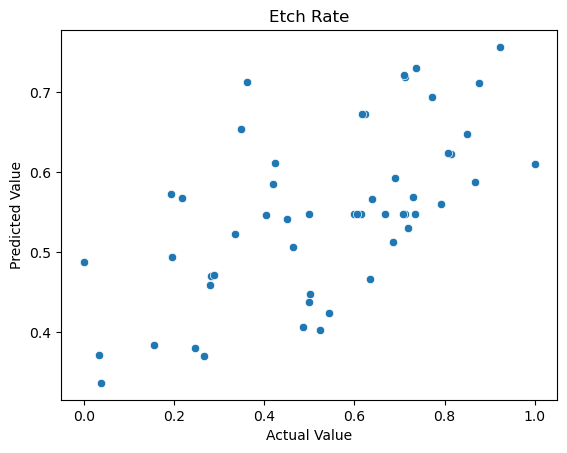

In [162]:
ax = sns.scatterplot(x=y_test_etch_rate, y=predictions_etch_rate)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Etch Rate')
# plt.savefig('rie_ap_etch_rate.png')

[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Etch Uniformity')]

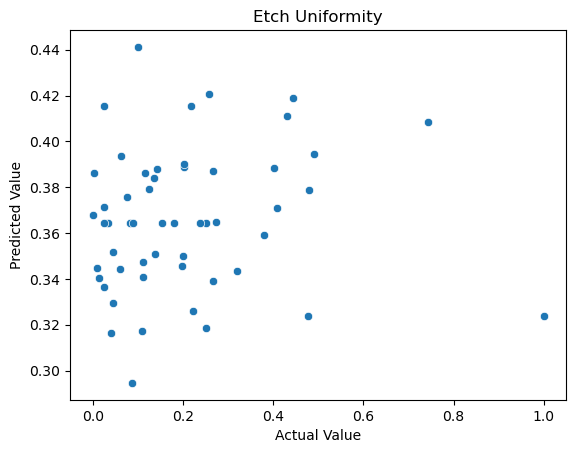

In [152]:
ax = sns.scatterplot(x=y_test_etch_uni, y=predictions_etch_uni)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Etch Uniformity')
# plt.savefig('rie_ap_etch_uni.png')

[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Oxide Selectivity')]

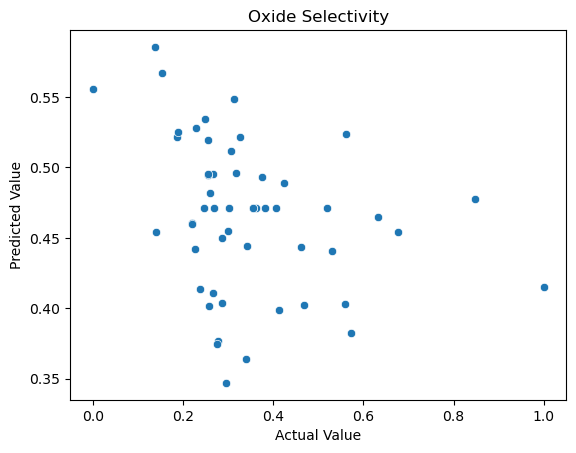

In [154]:
ax = sns.scatterplot(x=y_test_ox_sel, y=predictions_ox_sel)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Oxide Selectivity')
# plt.savefig('rie_ap_ox_sel.png')

[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Photoresist Selectivity')]

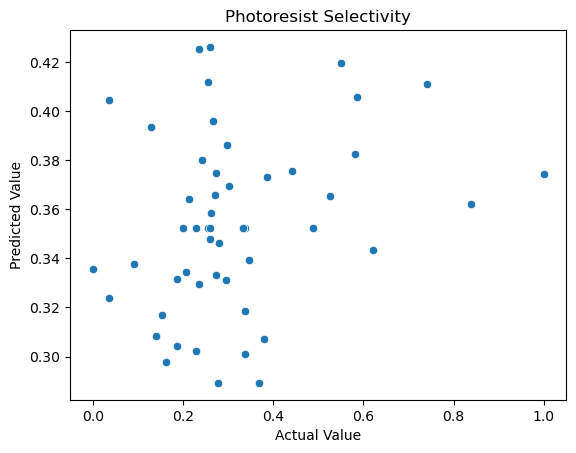

In [156]:
ax = sns.scatterplot(x=y_test_pho_sel, y=predictions_pho_sel)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Photoresist Selectivity')
# plt.savefig('rie_ap_photo_sel.png')

In [157]:
errors = y_scaled - predictions

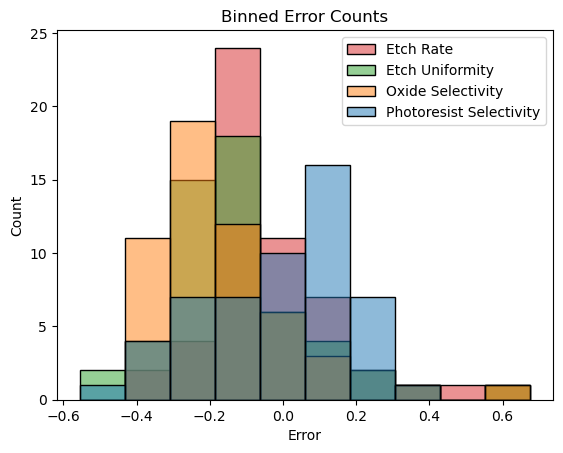

In [160]:
ax = sns.histplot(data=errors, bins=10)
ax.set(xlabel='Error', title='Binned Error Counts')
ax.legend(['Etch Rate', 'Etch Uniformity', 'Oxide Selectivity', 'Photoresist Selectivity'])
# plt.savefig('rie_errors.png')